<h1 style = "font-size:3rem;color:orange">Actividad C1 P1 Img2 - José Jesús La Casa Nieto</h1>

In [42]:
from skimage import io
from skimage import morphology
from skimage.measure import regionprops
from skimage.measure import label
from scipy import ndimage
from tabulate import tabulate
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

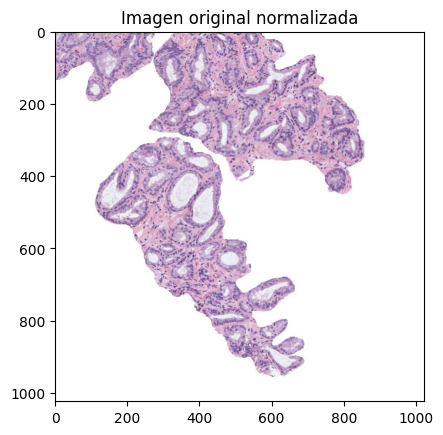

In [43]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB

histo_1_rgb = io.imread("histo_2.jpg", as_gray=False)
img = histo_1_rgb.copy()

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]

normalized_img = img.astype('uint8') / 255

# Visualizar la imagen

plt.imshow(normalized_img)
plt.title("Imagen original normalizada")
plt.show()

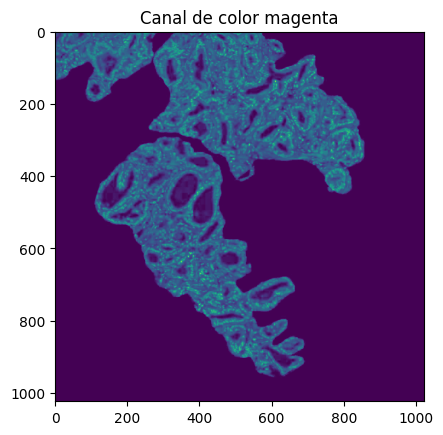

In [44]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)

with np.errstate(invalid='ignore', divide='ignore'):    # Extracción de los colores secundarios
    K = 1 - np.max(normalized_img, axis=2)
    C = (1 - normalized_img[:,:,0] - K)/(1 - K)
    M = (1 - normalized_img[:,:,1] - K)/(1 - K)
    Y = (1 - normalized_img[:,:,2] - K)/(1 - K)

CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')   # Apilar los canales de color y convertir a tipo de dato 'uint8'
C,M,Y,K = cv2.split(CMYK)

# Visualizar la imagen del canal magenta

plt.imshow(M)
plt.title("Canal de color magenta")
plt.show()

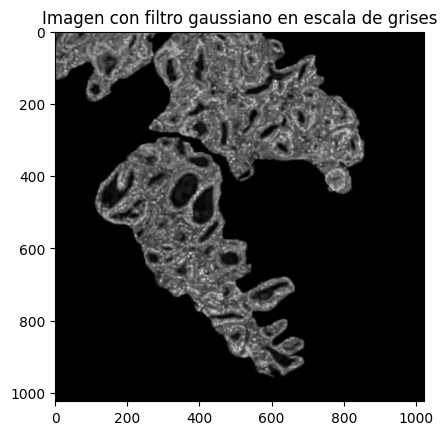

Rango de píxeles de la imagen: [0, 136]
Tipo de dato: uint8


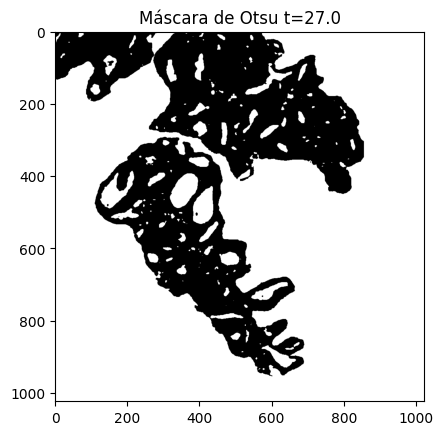

Rango de los píxeles de la imagen: [0 1]


In [45]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

M_gaussian = cv2.GaussianBlur(M, (5, 5), 0)     # Aplicación de un filtro gaussiano de dimensión (5x5)

plt.imshow(M_gaussian, cmap='gray')
plt.title("Imagen con filtro gaussiano en escala de grises")
plt.show()

print(f"Rango de píxeles de la imagen: [{np.min(M_gaussian)}, {np.max(M_gaussian)}]")      # Muestro los parámetros porque la entrada de la función cv2.threshold() debe ser una imagen no normalizada y con tipo de dato 'uint8'
print("Tipo de dato:", M_gaussian.dtype)

t, M_mask = cv2.threshold(M_gaussian, 0, 1, cv2.THRESH_OTSU)   # Fijo el umbral con el método de Otsu. El valor 0 es por defecto y 1 es el valor máximo de la máscara
M_inv = 1 - M_mask      # Invierto la imagen para mostrar el lumen y el fondo con valores de 1 y el resto con valores de 0

plt.imshow(M_inv, cmap='gray')
plt.title('Máscara de Otsu t=' + str(t))
plt.show()
print("Rango de los píxeles de la imagen:", np.unique(M_inv))

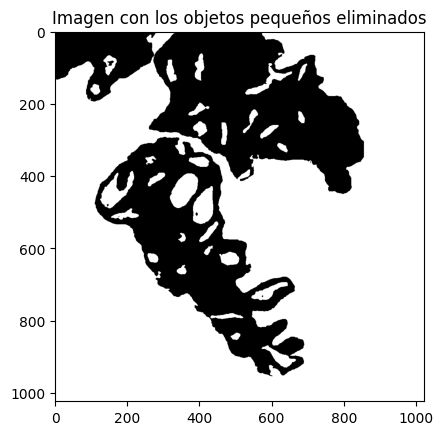

In [46]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizar la máscara resultante

M_inv = M_inv.astype('bool')    # La página de la librería indica que la función trabaja diferente entre datos booleanos y de tipo [0, 1]. En mi caso, ha funcionado mejor en datos booleanos.
M_cleaned = morphology.remove_small_objects(M_inv, 300)

plt.imshow(M_cleaned, cmap='gray')
plt.title("Imagen con los objetos pequeños eliminados")
plt.show()

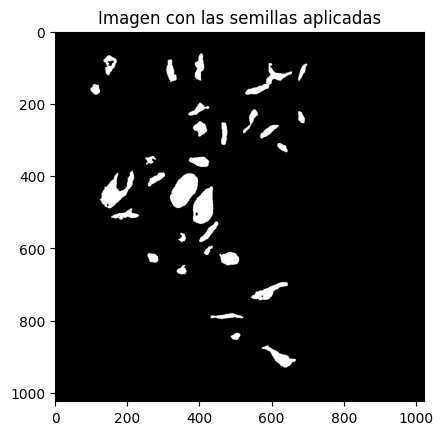

In [47]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

M_cleaned_int = M_cleaned.astype(np.uint8)      # Convierto la imagen de tipo bool a entero para que la función cv2.connectedComponentsWithStats() pueda trabajarla
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(M_cleaned_int, connectivity=8)

areas = stats[1:, cv2.CC_STAT_AREA]     # Selecciona las áreas de los componentes, excepto de la fila 0 (la primera fila es lo que la función cv2.connectedComponentsWithStats() considera como fondo de la imagen)

areas_sorted = np.sort(areas)[::-1]     # Ordena las áreas de mayor a menor

# Obtengo los dos primeros valores de la lista ordenada. Esos valores se corresponden con el fondo de nuestra imagen
umbral_area_1 = areas_sorted[0]

# Algoritmo para determinar las etiquetas de los objetos de la imagen. Con esas etiquetas, puedo determinar las coordenadas de los centroides de esos objetos
lumen_labels = []
for labl, stat in enumerate(stats[1:], start=1):  # Ignorar el fondo. La primera fila, es la etiqueta que la función considera como fondo
    area = stat[cv2.CC_STAT_AREA]
    if area >= umbral_area_1:  # Umbral para determinar las etiquetas de los objetos con mayor área (las áreas mayores las he determinado antes del algoritmo)
        lumen_labels.append(labl)

# Seleccionar las coordenadas de los puntos en las regiones más grandes, a través de sus centroides (los centroides los proporciona la función cv2.connectedComponentsWithStats())
lumen_seeds = []
for labl in lumen_labels:
    centroid = centroids[labl]
    lumen_seeds.append((int(centroid[0]), int(centroid[1])))        # Añado las coordenadas sobre las que voy a colocar la semilla para eliminar el fondo de la imagen

# Aplicar cv2.floodFill() para introducir dos semillas de 0 en las coordenadas seleccionadas en el paso anterior
for seed in lumen_seeds:
    cv2.floodFill(M_cleaned_int, None, seed, 0)

# Representación de la imagen con las semillas aplicadas
plt.imshow(M_cleaned_int, cmap='gray')
plt.title("Imagen con las semillas aplicadas")
plt.show()

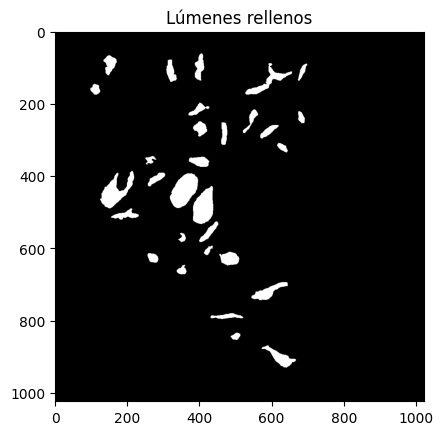

In [48]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

M_cleaned_int = ndimage.binary_fill_holes(M_cleaned_int).astype(int)

plt.imshow(M_cleaned_int, cmap='gray')
plt.title("Lúmenes rellenos")
plt.show()

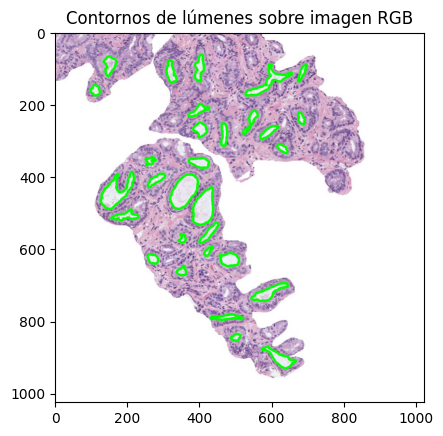

In [49]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

M_cleaned_uint8 = M_cleaned_int.astype(np.uint8)    # Convierto la imagen a datos tipo np.uint8 para trabajar con la función cv2.findContours()
contours, _ = cv2.findContours(M_cleaned_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)     # La función utiliza la imagen binaria con formato np.uint8, un modo de recuperación de contornos (cv2.RETR_EXTERNAL) que devuelve los contornos externos y un método de aproximación (cv2.CHAIN_APPROX_SIMPLE) que optimiza el cálculo de los contornos dejando sólo los puntos finales
img = cv2.drawContours(histo_1_rgb.copy(), contours, -1, (0, 255, 0), thickness=5)       # Función para dibujar los contornos (contours) sobre la imagen RGB (img). El valor -1 indica que se tienen que dibujar todos los contornos. Si fuese positivo, se dibujaría el de la posición correspondiente

plt.imshow(img, cmap='gray')
plt.title("Contornos de lúmenes sobre imagen RGB")
plt.show()

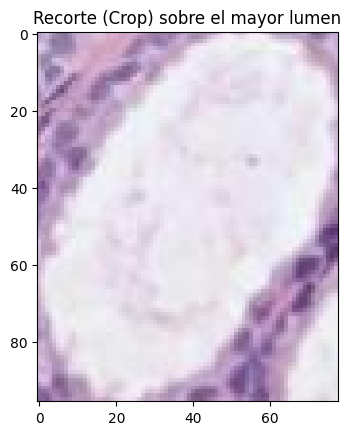

In [50]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

# Convierto la imagen binaria (M_cleaned_int) a una imagen de etiquetas para tener acceso a cada objeto por separado
lab, num = label(M_cleaned_int, return_num=True)
proper = regionprops(lab)

# Determino el mayor área de los lúmenes conocidos
max_area = -1
lumen = -1

for obj in proper:
    if obj.area > max_area:
        max_area = obj.area
        lumen = obj.label

histo_1_rgb_copy = histo_1_rgb.copy()
obj = lab == lumen      # Selecciono la etiqueta del objeto que tiene mayor área (almacenada en la variable lumen)
obj = obj.astype('uint8')

prop = regionprops(obj)     # Extraigo la bounding box del lumen para poder cropear la imagen con sus coordenadas
bbox = prop[0].bbox

y_min, x_min, y_max, x_max = bbox
max_lumen = histo_1_rgb[y_min:y_max, x_min:x_max].copy()    # Aplico un crop a la imagen RGB con el contorno del lumen en verde (variable img)

plt.imshow(max_lumen)
plt.title("Recorte (Crop) sobre el mayor lumen")
plt.show()

In [51]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Excentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

headers = ['', 'Lumen']

A, BB, CA, E, ED, EX, FD, MA, MiA, OR, P, S, CO = ['Área'], ['Área de la bounding box'], ['Área convexa'], ['Excentricidad'], \
['Diámetro equivalente'], ['Extensión'], ['Diámetro Feret'], ['Longitud del eje mayor'], ['Longitud del eje menor'], \
['Orientación'], ['Perímetro'], ['Solidez'], ['Compacidad']

A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
EX.append(np.round(prop[0].extent, 4))
FD.append(np.round(prop[0].area/prop[0].bbox_area, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
OR.append(np.round(prop[0].orientation, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))
CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))

my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(FD), tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO)]

print(tabulate(my_data, headers=headers))

                             Lumen
-----------------------  ---------
Área                     4887
Área de la bounding box  7488
Área convexa             5020
Excentricidad               0.8355
Diámetro equivalente       78.8817
Extensión                   0.6526
Diámetro Feret              0.6526
Longitud del eje mayor    106.646
Longitud del eje menor     58.5958
Orientación                -0.5612
Perímetro                 280.392
Solidez                     0.9735
Compacidad                  0.7811
